In [4]:
from glob import glob
from matplotlib import pyplot as plt
import cv2
import random
import numpy as np
from numpy.linalg import inv

In [5]:
def show_image(location, title, img, width=None):
    if width is not None:
        plt.figure(figsize=(width, width))
    plt.subplot(*location)
    plt.title(title, fontsize=8)
    plt.axis('off')
    if len(img.shape) == 3:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
    if width is not None:
        plt.show()
        plt.close()

In [ ]:
plt.figure(figsize=(20,40))
loc_list = glob("./ms_coco_test_images/*.jpg")
for index in range(len(loc_list)):
    img_file_location = loc_list[index]
    image = plt.imread(img_file_location)
    image = cv2.resize(image, (320,240))
    show_image((6,2,index + 1), "Image Size: "+ str(image.shape), image)
plt.show()
plt.close()

## Let's now read in one image and start experimenting with it.

Like the paper describes we will take the image and do the following to prepare it:
1. Resize to 320x240
2. Convert to grayscale

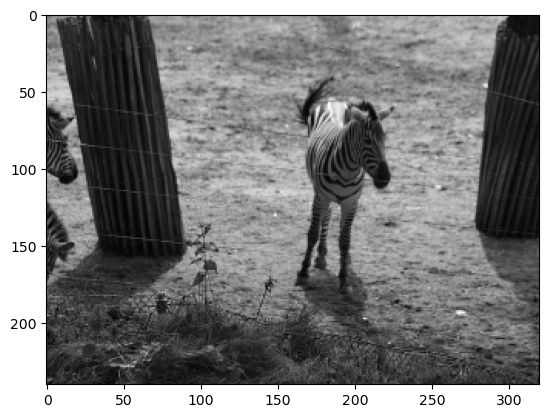

In [7]:
test_image = plt.imread(loc_list[8])
test_image = cv2.resize(test_image, (320, 240))
test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2GRAY)
plt.imshow(test_image, cmap='gray')
plt.show()

### Now we need to pick a position `P` that'll be the location of the patch.

Parameters we will use are the following:
* `rho = 32`
* `patch_size = 128x128`

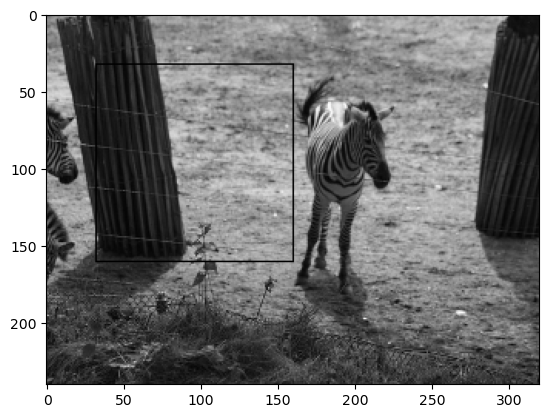

In [8]:
rho          = 32
patch_size   = 128

top_point    = (32,32)
left_point   = (patch_size+32, 32)
bottom_point = (patch_size+32, patch_size+32)
right_point  = (32, patch_size+32)

annotated_image = test_image.copy()

four_points = [top_point, left_point, bottom_point, right_point]

cv2.polylines(annotated_image, np.int32([four_points]), 1, (0,0,0))
plt.imshow(annotated_image, cmap='gray')
plt.show()

## Now we will create four random (delta_x, delta_y) tuples that are in the range [-rho, rho].

These 4 tuples are used to perturb four corners of the rectange patch. Then we show the perturbed patch.

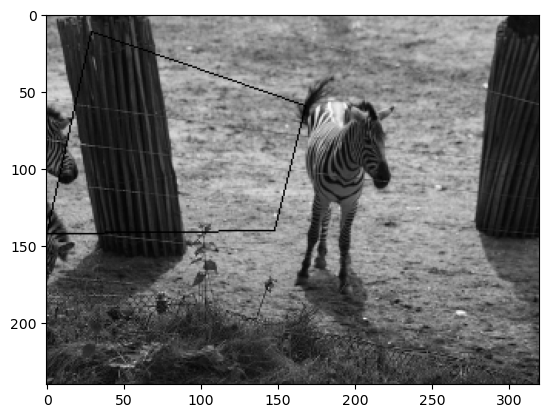

In [9]:
perturbed_four_points = []
for point in four_points:
    perturbed_four_points.append((point[0] + random.randint(-rho,rho), point[1]+random.randint(-rho,rho)))

perturbed_annotated_image = test_image.copy()
cv2.polylines(perturbed_annotated_image, np.int32([perturbed_four_points]), 1, (0,0,0))
plt.imshow(perturbed_annotated_image, cmap='gray')
plt.show()

## Now that we have both the original patch and the perturbed patch we generate the homography matrix using the opencv2  `getPerspectiveTransform` method.

In [10]:
# h is the homography matrix
H = cv2.getPerspectiveTransform( np.float32(four_points), np.float32(perturbed_four_points) )
print(H)

[[ 2.25851728e+00 -2.69759461e-01 -2.91110391e+01]
 [ 7.85584158e-01  1.24852855e+00 -5.19943197e+01]
 [ 5.74721592e-03  2.10985575e-04  1.00000000e+00]]


## Now we generate the inverse matrix of the homorgrapy matrix.

This wil be used to warp the original image. In the paper this is denoted as `I'`

In [11]:
H_inverse = inv(H)
print(H_inverse)

[[ 3.76960929e-01  7.88992376e-02  1.50760366e+01]
 [-3.24556908e-01  7.26035847e-01  2.83015511e+01]
 [-2.09799903e-03 -6.06634046e-04  9.07383544e-01]]


## Now we genenerate the Image using opencv2  `warpPerspective` method.


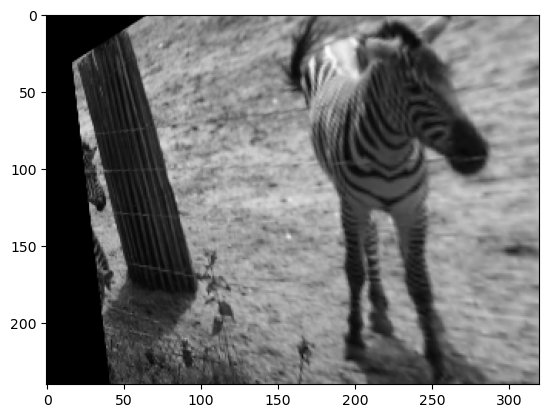

In [12]:
warped_image = cv2.warpPerspective(test_image,H_inverse, (320,240))
plt.imshow(warped_image, cmap='gray')
plt.show()

## Now that we have image `I'` we place a patch at the same position `P`.

This patch is denoted as `Ip` in the paper.

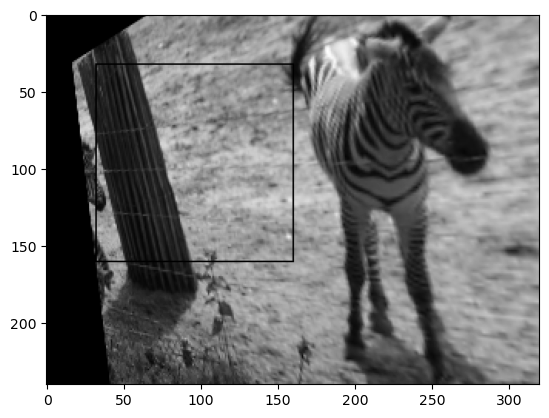

In [13]:
annotated_warp_image = warped_image.copy()
cv2.polylines(annotated_warp_image, np.int32([four_points]), 1, (0,0,0))
plt.imshow(annotated_warp_image, cmap='gray')
plt.show()

## Finally we generate the datum that we will feed into the model. This datum tuple will consist of the following:

1. I<sup>p</sup> = the patch from the original paper.
2. I<sup>'</sup><sub>p</sub> = the patch from warped Image
3. `perturbed_four_points` = the delta points that were used to generate the homography matrix

NOTE: the two patches are stacked to create a 2D image of size 128x128. Hence the final feature size will be (128,128, 2) and the label will be the perturbed four points.

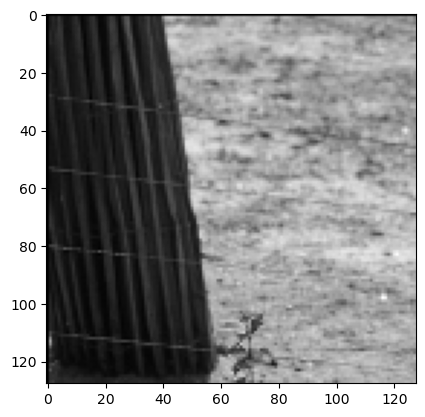

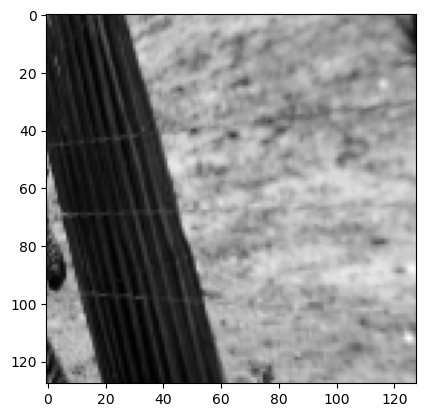

In [14]:
Ip1 = annotated_image[top_point[1]:bottom_point[1],top_point[0]:bottom_point[0]]
Ip2 = warped_image[top_point[1]:bottom_point[1],top_point[0]:bottom_point[0]]

plt.imshow(Ip1, cmap='gray')
plt.show()

plt.imshow(Ip2, cmap='gray')
plt.show()

In [16]:
training_image = np.dstack((Ip1, Ip2))
print(training_image.shape)

H_four_points = np.subtract(np.array(perturbed_four_points), np.array(four_points))
print(H_four_points)

(128, 128, 2)
[[ -3 -21]
 [  8  27]
 [-12 -20]
 [-32 -18]]


## Final Datum is below

In [17]:
datum = (training_image, H_four_points)
print(datum)

(array([[[  0, 110],
        [  0,  42],
        [  0,  38],
        ...,
        [  0, 118],
        [  0,  80],
        [  0,  42]],

       [[  0,  87],
        [ 27,  51],
        [ 37,  38],
        ...,
        [142, 102],
        [142,  69],
        [118,  33]],

       [[  0,  64],
        [ 25,  67],
        [ 37,  37],
        ...,
        [137,  88],
        [141,  66],
        [125,  27]],

       ...,

       [[  0,  49],
        [ 45,  76],
        [ 47,  77],
        ...,
        [170, 170],
        [162, 163],
        [155, 155]],

       [[  0,  63],
        [ 44,  97],
        [ 45,  47],
        ...,
        [146, 180],
        [155, 177],
        [154, 167]],

       [[  0,  69],
        [ 50, 119],
        [ 56,  20],
        ...,
        [163, 175],
        [156, 178],
        [165, 172]]], dtype=uint8), array([[ -3, -21],
       [  8,  27],
       [-12, -20],
       [-32, -18]]))
